In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.integrate import quad
from scipy.integrate import tplquad


%matplotlib inline


In [2]:
data=pd.read_csv('mock_cluster_4.csv')
data.rename(columns={'Unnamed: 0': 'radius2D', '0':'shellId', '1':'x', '2':'y', '3':'z', '4':'v'},inplace=True)
data.radius2D = np.sqrt(np.power(data.x,2)+np.power(data.y,2))
data.describe()


,radius2D,shellId,x,y,z,v
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,154.205904,4.500000,4.662470,-7.206179,3.370333,6.829582
std,222.522683,2.873719,192.513279,190.222250,188.251102,295.177409
min,0.282092,0.000000,-885.504044,-914.696833,-935.733984,-1800.790183
25%,7.787780,2.000000,-21.543062,-22.828401,-19.806140,-99.982980
50%,47.379177,4.500000,0.260367,-0.425345,0.406701,2.582063
75%,212.501908,7.000000,28.387367,20.662865,24.898741,119.634603
max,982.440911,9.000000,939.847104,952.085239,864.004359,1979.414230


In [3]:
N_total =  data['x'].count()
del data['x']
del data['y']
del data['z']
del data['shellId']
print N_total

1000


In [4]:
# here created the grid cell boundaries for our entries 
def get_the_grid(arr):
    # 1D array
    # has to be sorted!!! 
    arr = np.array(arr)
    grid = (arr[1:]+arr[:-1])/2.
    #print grid.shape
    #print arr[:-1].shape
    grid = np.append(2.*arr[0]-grid[0], grid)
    grid = np.append(grid, 2.*arr[-1]-grid[-1])
    #grid = np.append(grid, 2.*arr[arr.shape[0]-1]-grid[-1])
    grid_low = grid[:-1]
    grid_up = grid[1:]
    return grid_low, grid_up                                                                                                                                                   

data = data.sort(['radius2D'])
grid_low, grid_up = get_the_grid(data['radius2D'])
if grid_low[0]<0:
    grid_low[0]=0.
#print grid_low.shape, grid_up.shape, data.radius2D.shape
data['dr_in']= grid_low
data['dr_out'] = grid_up

data = data.sort(['v'])
grid_low, grid_up = get_the_grid(data['v'])
data['dv_in']= grid_low
data['dv_out'] = grid_up



#data_vel_sort = data.sort(['v'])

In [19]:
data  =  data.sort(['radius2D'])
v_mean = 6.829582
data['v_gauss_sq'] = np.power(data.v-v_mean, 2)
data['z_range']  = np.sqrt(1000.**2 - np.power(np.array(data.radius2D),2))
#print data.v_gauss_sq

In [49]:
def nu_f(z, r2D, nu_0, k):
    return nu_0*z*np.power((np.power(r2D,2) + z**2),-k/2.)*np.power((z**2/np.power(r2D,2) +1), k/2.)* \
           hyp2f1(0.5, k/2., 1.5, -(z**2/np.power(r2D,2)))

def nu_int(z, r2D, nu_0, k):
    return nu_0*2.*np.pi*r2D/np.power((np.power(r2D,2)+z**2),k/2.)
    
def sig_f_sq(z, r2D, sig_0, m):
    nu_0 = sig_0 # change this later
    k = m
    return sig_0**2/np.power(np.power(z,2)+np.power(r2D,2)  , m) # because we use sigma square, cause thats how gaussians add

def sig_f(z, r2D, sig_0, m):
    nu_0 = sig_0 # change this later
    k = m
    return sig_0/np.power(np.power(z,2)+np.power(r2D,2)  , m/2.) # because we use sigma square, cause thats how gaussians add


def vel_spread(v, sigma2D, v_mean, Ndr):
    return Ndr/(np.sqrt(2.*np.pi)*sigma2D)*np.exp(-np.power((v-v_mean),2)/(2.*np.power(sigma2D,2)))

            
def dNdrdv(z, r2D, v, sig_0, m, nu_0, k, v_mean=6.829582):
    sigma = sig_f(z, r2D, sig_0, m)
    return 2.*np.pi*sig_0**2/np.power(np.power(z,2)+np.power(r2D,2)  , m)*\
            1./(np.sqrt(2.*np.pi)*sigma)*np.exp(-np.power((v-v_mean),2)/(2.*np.power(sigma,2)))
    
def dNdrdv2(z, r2D, v_sq, sig_0, m, nu_0, k):
    return np.sqrt(2.*np.pi)*r2D*nu_0/sig_0*np.power(np.power(r2D,2)+np.power(z,2),(m-k)/2.)\
            *np.exp(-0.5*v_sq/sig_0**2*np.power(np.power(r2D,2)+np.power(z,2),m))
def dNdrdv3(z, r2D, v_sq, sig_0, m, nu_0, k):
    u = np.power(r2D,2)+np.power(z,2)  
    return np.sqrt(2.*np.pi)*r2D*nu_0/sig_0*np.power(u,(m-k)/2.)\
            *np.exp(-0.5*v_sq/sig_0**2*np.power(u,m))

def dNdrdv4(z, r2D, m, f, alpha, beta):
    u = np.power(r2D,2)+np.power(z,2)  
    return alpha*np.power(u,f)*np.exp(beta*np.power(u,m))

def log_likelihood(sig_0, m, nu_0, k):
    # note that everything here is performed only on cells that actually have galaxies in them
    alpha = np.sqrt(2.*np.pi)*np.array(data.radius2D)*nu_0/sig_0
    beta = -0.5*np.array(data.v_gauss_sq)/sig_0**2
    f = (m-k)/2.
    dN = 2.*np.array([quad(dNdrdv4, 0., z, args=(r2D, m, f, a, b)) \
                   for z, r2D,a ,b in zip(np.array(data.z_range), np.array(data.radius2D), alpha, beta)])
    return np.sum(-dN[:,0]+np.log(dN[:,0]))

def log_prior(sig_0, m, nu_0, k):
    return 0.
    
def log_posterior(sig_0, m, nu_0, k):
    return (log_likelihood(sig_0, m, nu_0, k) + log_prior(sig_0, m, nu_0, k))
# initial parameters (from actual distribution used)
nu_0_th = 11.5200189254
k_th = 3.
sig_0_th = 1000.
m_th = 0.2 
v_mean =6.829582 #52.580055# taken from the data

#import time
#tic = time.clock()
#toc = time.clock()
#print toc-tic

In [47]:
%%timeit
log_likelihood(sig_0_th, m_th, nu_0_th, k_th)

1 loops, best of 3: 3.96 s per loop


In [26]:
def run_MC(params, par_steps, nsteps, burn_in = 0):
    sig0, m, nu0, k = params
    sig_step, m_step, nu_step, k_step = par_steps
    chain = []
    probs = []
    naccept = 0
    #print 'Running MC for', nsteps, 'steps'
    log_prob_old = log_posterior(sig0, m, nu0, k)

    for i in range(nsteps+burn_in):
        sig0new = sig0 + np.random.normal() * sig_step
        mnew = m + np.random.normal() * m_step
        nu0new = nu0 + np.random.normal() * nu_step
        knew = k + np.random.normal() * k_step


        log_prob_new = log_posterior(sig0new, mnew, nu0new, knew)

        if (np.exp(log_prob_new - log_prob_old) > np.random.uniform()):
            sig0 = sig0new
            m = mnew
            nu0 = nu0new
            k = knew
            log_prob_old = log_prob_new
            if (i > burn_in): #measure acceptance rate after burn-in only
                naccept += 1
            else:
                pass

        chain.append((sig0, m, nu0, k))
        probs.append((log_prob_old))
    print 'Acceptance fraction:', naccept/float(nsteps)
    return chain[burn_in:], probs[burn_in:]


In [27]:
nu_0_th = 12
k_th = 2.5
sig_0_th = 1100.
m_th = 0.5 

params = (sig_0_th, m_th, nu_0_th, k_th)
par_steps = (10. ,0.02,1. ,0.2)
chain, probs= run_MC(params, par_steps, 100)

Acceptance fraction: 0.19


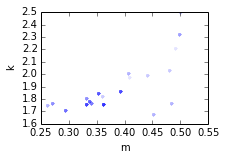

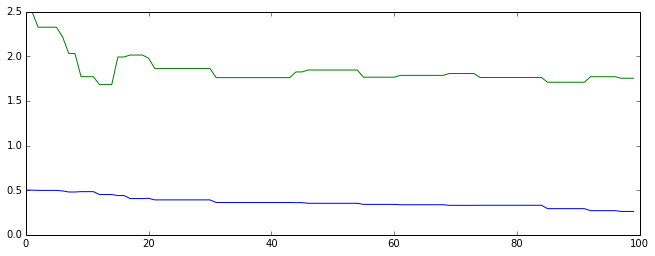

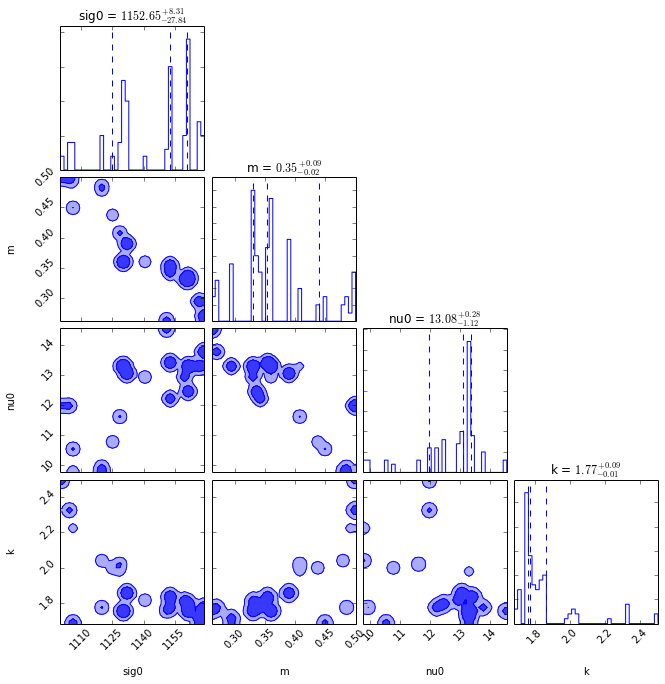

In [31]:
m_arr = [m for sig0, m, nu0, k in chain]
k_arr = [k for sig0, m, nu0, k in chain]
f = plt.figure(figsize=(3,2))
plt.clf()
plt.plot(m_arr, k_arr, 'b.', alpha=0.1)
plt.xlabel('m')
plt.ylabel('k')
f = plt.figure(figsize=(11,4))
plt.plot(m_arr, color='blue', label="m")
plt.plot(k_arr, color='green', label="k")
import corner
corner.corner(chain, labels=['sig0','m', 'nu0', 'k'], quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], color='b', bins=40, smooth=1.0);
plt.show()


In [50]:
chain1, probs1= run_MC(params, par_steps, 5000)

KeyboardInterrupt: 